# Import Necessary Libraries

In [ ]:
import os
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
import pandas as pd

# Load the dataset
file_path = "/content/enron-email.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')


#Information about the dataset

In [ ]:
# Display basic dataset information
print("Dataset Information:")
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message     49997 non-null  object
 1   Category    49886 non-null  object
 2   Unnamed: 2  3 non-null      object
dtypes: object(3)
memory usage: 1.1+ MB
None


In [ ]:
print("\nFirst Few Rows:")
df.head()


First Few Rows:


,Message,Category,Unnamed: 2
0,Subject: christmas tree farm pictures\r,ham,NaN
1,Subject: re : rankings\r thank you .\r,ham,NaN
2,Subject: leadership development pilot\r sally ...,ham,NaN
3,Subject: key dates and impact of upcoming sap ...,ham,NaN
4,Subject: key hr issues going forward a ) year ...,ham,NaN


In [ ]:
print("\nDataset Shape:", df.shape)



Dataset Shape: (50000, 3)


In [ ]:
print("\nColumn Names:", df.columns)



Column Names: Index(['Message', 'Category', 'Unnamed: 2'], dtype='object')


In [ ]:
#target (am or spam)
df['Category'].unique()

array(['ham', nan, ' [...]"', 'spam'], dtype=object)

#Data Cleaning and Preprocessing

In [ ]:
# Drop unnecessary column if it exists
df = df.drop(columns=['Unnamed: 2'], errors='ignore')

In [ ]:
#check for missing values
df.isnull().sum()

,0
Message,3
Category,114


there are few missing values, so we will handling them

In [ ]:
# Drop rows with missing values
df.dropna(subset=['Message', 'Category'], inplace=True)

In [ ]:
#check for missing values again
df.isnull().sum()

,0
Message,0
Category,0


In [ ]:
# Function to clean email text
def clean_email_text(text):
    if pd.isnull(text):
        return ""

    # Remove email headers (Subject, From, To, Cc, Date)
    text = re.sub(r'(?i)(Subject|From|To|Cc|Date): .*?\n', '', text)

    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove special characters and punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text



In [ ]:
# Apply text cleaning to the 'Message' column
df['Processed_Message'] = df['Message'].apply(clean_email_text)

# Display cleaned dataset information
print("\nDataset after Preprocessing:")
print(df[['Message', 'Processed_Message']].head())


Dataset after Preprocessing:
                                             Message  \
0           Subject: christmas tree farm pictures\r    
1            Subject: re : rankings\r thank you .\r    
2  Subject: leadership development pilot\r sally ...   
3  Subject: key dates and impact of upcoming sap ...   
4  Subject: key hr issues going forward a ) year ...   

                                   Processed_Message  
0               subject christmas tree farm pictures  
1                      subject re rankings thank you  
2  subject leadership development pilot sally wha...  
3  subject key dates and impact of upcoming sap i...  
4  subject key hr issues going forward a year end...  


In [ ]:
# Drop unnecessary columns
df = df[['Processed_Message', 'Category']]

<ipython-input-44-873f2fbfc809>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Category'], palette="coolwarm")


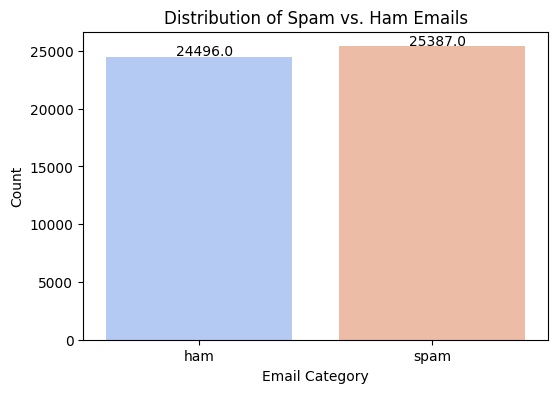

In [ ]:
# Count the number of spam and ham emails
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Category'], palette="coolwarm")

# Add labels and title
plt.xlabel("Email Category")
plt.ylabel("Count")
plt.title("Distribution of Spam vs. Ham Emails")

# Display the count above bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 100))

plt.show()


In [ ]:
# Convert 'ham' to 0 and 'spam' to 1
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})


#Text Vectorization using TF-IDF
We use TF-IDF (Term Frequency-Inverse Document Frequency) to convert text into numerical form.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=500)  # Use 500 most important words

# Transform the text data
X = vectorizer.fit_transform(df['Processed_Message'])

# Target variable (Spam/Ham)
y = df['Category']

print(" Shape of feature matrix:", X.shape)


 Shape of feature matrix: (49883, 500)


#Train-Test Split


In [ ]:
# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")


Training Samples: 39906, Testing Samples: 9977


#Models
Train Naïve Bayes and SVM

In [ ]:
# Initialize models
nb_model = MultinomialNB()
svm_model = SVC(kernel='linear')

In [ ]:
# Train Naïve Bayes
nb_model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Train SVM
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

#Model Evaluation
* Naïve Bayes is a probabilistic classifier that performs well on text classification problems because of its independence assumption.
* SVM is chosen because it works well with high-dimensional text data and can create clear decision boundaries.

In [ ]:
# Make predictions
nb_preds = nb_model.predict(X_test)
svm_preds = svm_model.predict(X_test)

In [ ]:
# Evaluate Naïve Bayes
print("\n🔹 Naïve Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))



🔹 Naïve Bayes Performance:
Accuracy: 0.9542948782199058
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4893
           1       0.94      0.97      0.96      5084

    accuracy                           0.95      9977
   macro avg       0.96      0.95      0.95      9977
weighted avg       0.95      0.95      0.95      9977



<Figure size 600x500 with 0 Axes>

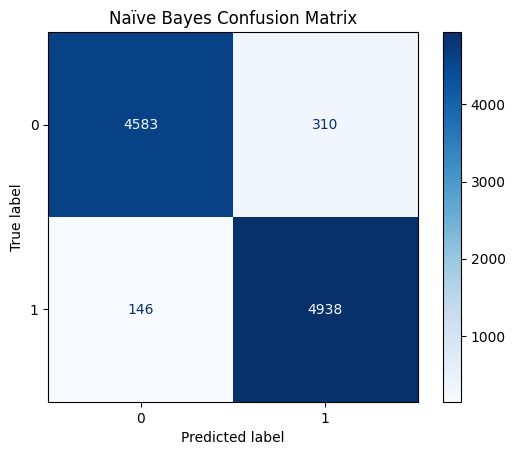

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix for Naïve Bayes
nb_cm = confusion_matrix(y_test, nb_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(nb_cm).plot(cmap="Blues", values_format="d")
plt.title("Naïve Bayes Confusion Matrix")
plt.show()


In [ ]:

# Evaluate SVM
print("\n🔹 SVM Performance:")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))


🔹 SVM Performance:
Accuracy: 0.9727372957802947
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4893
           1       0.96      0.98      0.97      5084

    accuracy                           0.97      9977
   macro avg       0.97      0.97      0.97      9977
weighted avg       0.97      0.97      0.97      9977



<Figure size 600x500 with 0 Axes>

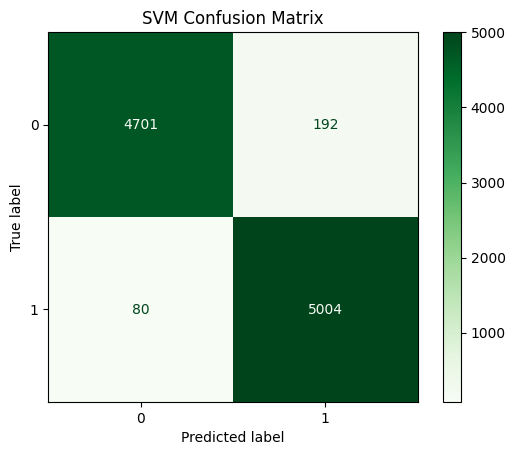

In [ ]:
# Generate confusion matrix for SVM
svm_cm = confusion_matrix(y_test, svm_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(svm_cm).plot(cmap="Greens", values_format="d")
plt.title("SVM Confusion Matrix")
plt.show()


#Compare Models

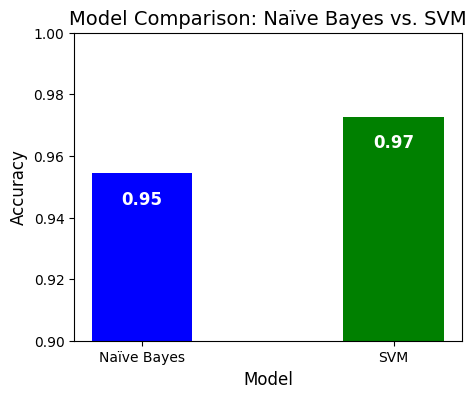

In [ ]:
import matplotlib.pyplot as plt

# Accuracy scores
nb_accuracy = accuracy_score(y_test, nb_preds)
svm_accuracy = accuracy_score(y_test, svm_preds)

# Bar Chart
plt.figure(figsize=(5, 4))
bars = plt.bar(["Naïve Bayes", "SVM"], [nb_accuracy, svm_accuracy], color=['blue', 'green'], width=0.4)  # Narrower bars
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Comparison: Naïve Bayes vs. SVM", fontsize=14)
plt.ylim(0.9, 1.0)  # Set y-axis range from 0.9 to 1.0

# Display accuracy values on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.01,
             f"{bar.get_height():.2f}", ha="center", color="white", fontsize=12, fontweight="bold")

plt.show()
